<a href="https://colab.research.google.com/github/RogMaverick18/ML-Lab-assignments/blob/main/ML_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A1. Evaluate the intraclass spread and interclass distances between the classes in your dataset. If your data deals with multiple classes, you can take any two classes. Steps below (refer below diagram for understanding):
•
Calculate the mean for each class (also called as class centroid) (Suggestion: You may use numpy.mean() function for finding the average vector for all vectors in a given class. Please define the axis property appropriately to use this function. EX: feat_vecs.mean(axis=0))
•
Calculate spread (standard deviation) for each class (Suggestion: You may use numpy.std() function for finding the standard deviation vector for all vectors in a given class. Please define the axis property appropriately to use this function.)
•
Calculate the distance between mean vectors between classes (Suggestion: numpy.linalg.norm(centroid1 – centroid2) gives the Euclidean distance between two centroids.)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scipy.spatial.distance import minkowski
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

from google.colab import drive
drive.mount('/content/drive')

# Path to dataset folders
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/flowers"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "validation")

# Define Image Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load Pretrained ResNet Model for Feature Extraction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove final FC layer
model.eval()
model.to(device)

# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))  # Get class labels
        self.image_paths = []
        self.labels = []

        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for img_file in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, img_file))
                self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Extract Features using ResNet
def extract_features(dataset):
    loader = DataLoader(dataset, batch_size=32, shuffle=False)
    features = []
    labels = []

    with torch.no_grad():
        for images, lbls in loader:
            images = images.to(device)
            output = model(images)
            output = output.view(output.size(0), -1)  # Flatten
            features.append(output.cpu().numpy())
            labels.append(lbls.numpy())

    return np.vstack(features), np.hstack(labels)

# Load Dataset and Extract Features
train_dataset = ImageDataset(TRAIN_DIR, transform)
val_dataset = ImageDataset(VAL_DIR, transform)

X_train, y_train = extract_features(train_dataset)
X_test, y_test = extract_features(val_dataset)

#A4
# Choose any two classes (e.g., first two)
class1, class2 = 0, 1
train_indices = (y_train == class1) | (y_train == class2)
test_indices = (y_test == class1) | (y_test == class2)

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

# Compute Intraclass Spread and Interclass Distances
def compute_spread_and_distance(X, y, class1, class2):
    class1_vectors = X[y == class1]
    class2_vectors = X[y == class2]

    centroid1 = class1_vectors.mean(axis=0)
    centroid2 = class2_vectors.mean(axis=0)

    std_dev1 = class1_vectors.std(axis=0)
    std_dev2 = class2_vectors.std(axis=0)

    intraclass_distance1 = np.mean([np.linalg.norm(x - centroid1) for x in class1_vectors])
    intraclass_distance2 = np.mean([np.linalg.norm(x - centroid2) for x in class2_vectors])

    interclass_distance = np.linalg.norm(centroid1 - centroid2)

    print(f"Class {class1} - Mean: {centroid1[:5]}, Std Dev: {std_dev1[:5]}")
    print(f"Class {class2} - Mean: {centroid2[:5]}, Std Dev: {std_dev2[:5]}")
    print(f"Intraclass Distance for {class1}: {intraclass_distance1:.4f}")
    print(f"Intraclass Distance for {class2}: {intraclass_distance2:.4f}")
    print(f"Interclass Distance: {interclass_distance:.4f}")

compute_spread_and_distance(X_train, y_train, class1, class2)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s]


Class 0 - Mean: [0.20999624 0.38595703 0.6709144  0.19011126 0.31357974], Std Dev: [0.1752853  0.30052832 0.41909164 0.19483376 0.22437163]
Class 1 - Mean: [0.42477554 0.35395497 0.69276756 0.0751982  0.28414196], Std Dev: [0.1587962  0.23844697 0.33074576 0.08352941 0.1884013 ]
Intraclass Distance for 0: 13.1785
Intraclass Distance for 1: 10.6850
Interclass Distance: 10.5903


A2. Take any feature from your dataset. Observe the density pattern for that feature by plotting the histogram. Use buckets (data in ranges) for histogram generation and study. Calculate the mean and variance from the available data. (Suggestion: numpy.histogram()gives the histogram data. Plot of histogram may be achieved with matplotlib.pyplot.hist())

Feature 0 Mean: 0.3174
Feature 0 Variance: 0.0395


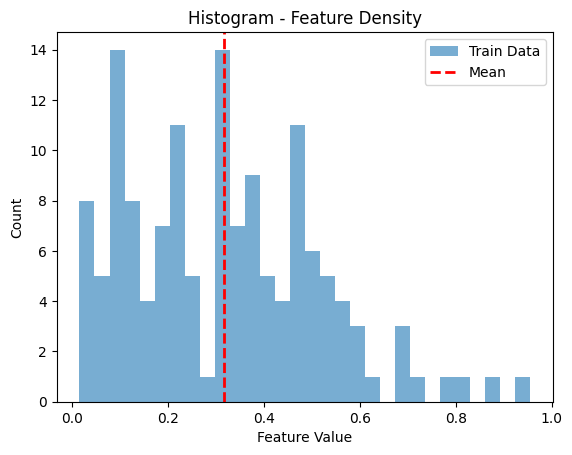

In [ ]:
# Compute Mean and Variance for the Selected Feature
feature_idx = 0  # Choosing the first feature for demonstration
feature_values = X_train[:, feature_idx]

mean_feature = np.mean(feature_values)
variance_feature = np.var(feature_values)

print(f"Feature {feature_idx} Mean: {mean_feature:.4f}")
print(f"Feature {feature_idx} Variance: {variance_feature:.4f}")

# Plot Histogram
plt.hist(feature_values, bins=30, alpha=0.6, label="Train Data")
plt.axvline(mean_feature, color='red', linestyle='dashed', linewidth=2, label="Mean")
plt.title("Histogram - Feature Density")
plt.xlabel("Feature Value")
plt.ylabel("Count")
plt.legend()
plt.show()

A3. Take any two feature vectors from your dataset. Calculate the Minkwoski distance with r from 1 to 10. Make a plot of the distance and observe the nature of this graph.

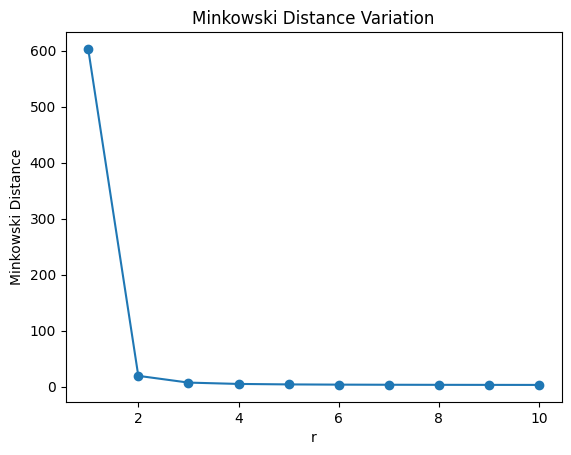

In [ ]:
# Compute Minkowski Distance for r = 1 to 10
sample_vec1, sample_vec2 = X_train[0], X_train[1]
r_values = list(range(1, 11))
minkowski_distances = [minkowski(sample_vec1, sample_vec2, r) for r in r_values]

plt.plot(r_values, minkowski_distances, marker="o")
plt.xlabel("r")
plt.ylabel("Minkowski Distance")
plt.title("Minkowski Distance Variation")
plt.show()

A4. Divide dataset in your project into two parts – train & test set. To accomplish this, use the train-test_split() function available in SciKit. See below sample code for help: >>> import numpy as np >>> from sklearn.model_selection import train_test_split >>> X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X is the feature vector set for your project and y is the class levels for vectors present in X.
Note: Before set split, make sure you have only two classes. If your project deals with multi-class problem, take any two classes from them.

In [ ]:
# Choose any two classes (e.g., first two)
class1, class2 = 0, 1
train_indices = (y_train == class1) | (y_train == class2)
test_indices = (y_test == class1) | (y_test == class2)

X_train, y_train = X_train[train_indices], y_train[train_indices]
X_test, y_test = X_test[test_indices], y_test[test_indices]

A5. Train a kNN classifier (k =3) using the training set obtained from above exercise. Following code for help: >>> import numpy as np >>> from sklearn.neighbors import KNeighborsClassifier >>> neigh = KNeighborsClassifier(n_neighbors=3) >>> neigh.fit(X, y)

In [ ]:
# Train k-NN Classifier (k=3)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

A6. Test the accuracy of the kNN using the test set obtained from above exercise. Following code for help. >>> neigh.score(X_test, y_test)
This code shall generate an accuracy report for you. Please study the report and understand it.

In [ ]:
# Test Accuracy
accuracy = knn.score(X_test, y_test)
print(f"Accuracy (k=3): {accuracy:.4f}")

Accuracy (k=3): 1.0000


A7. Use the predict() function to study the prediction behavior of the classifier for test vectors. >>> neigh.predict(X_test)
Perform classification for a given vector using neigh.predict(<<test_vect>>). This shall produce the class of the test vector (test_vect is any feature vector from your test set).

In [ ]:
# Predictions
y_pred = knn.predict(X_test)
print("Predictions:", y_pred)
print(classification_report(y_test, y_pred))

Predictions: [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



A8. Make k = 1 to implement NN classifier and compare the results with kNN (k = 3). Vary k from 1 to 11 and make an accuracy plot.

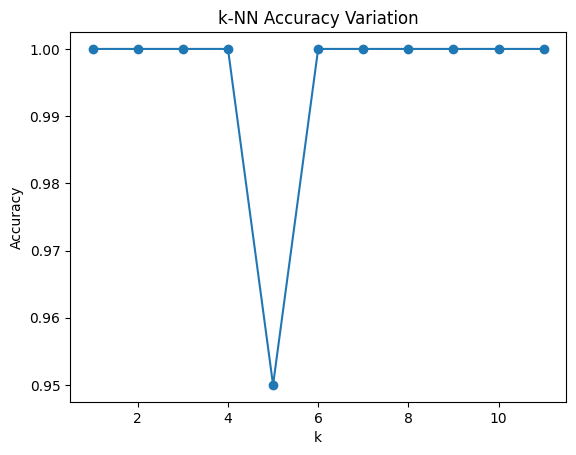

In [ ]:
# Evaluate for Different k Values
k_values = range(1, 12)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    accuracies.append(knn.score(X_test, y_test))

plt.plot(k_values, accuracies, marker="o")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.title("k-NN Accuracy Variation")
plt.show()

A9. Please evaluate confusion matrix for your classification problem. From confusion matrix, the other performance metrics such as precision, recall and F1-Score measures for both training and test data. Based on your observations, infer the models learning outcome (underfit / regularfit / overfit).

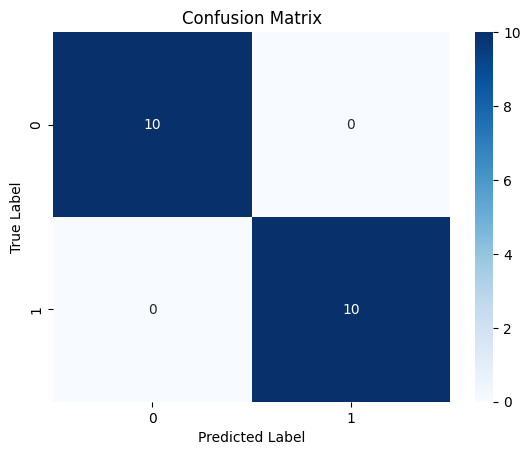

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[class1, class2], yticklabels=[class1, class2])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()